# Comparing Modlyn & Scanpy feature selection methods

In [1]:
!pip install 'modlyn[dev]'
!lamin init --storage test-modlyn

• resetting django module variables
→ connected lamindb: mikelkou/test-modlyn


In [2]:
import lamindb as ln
import modlyn as mn
import scanpy as sc
import pandas as pd
import seaborn as sns

sns.set_theme()
%config InlineBackend.figure_formats = ['svg']

→ connected lamindb: mikelkou/test-modlyn


In [3]:
ln.track()


→ loaded Transform('fTv8ikrKUXXJ0000'), re-started Run('Nx3qPK71...') at 2025-10-02 00:27:45 UTC
→ notebook imports: arrayloaders==0.0.3 lamindb==1.11.3 modlyn==0.0.7 pandas==2.2.3 scanpy==1.11.2 seaborn==0.13.2
• recommendation: to identify the notebook across renames, pass the uid: ln.track("fTv8ikrKUXXJ")


In [4]:
# Configuration: switch between in-memory and Dask loader
USE_DASK = True  # set False to use in-memory path
ZARR_UID = "1xSHIdfBjfUdxKHm0000"  # example UID; change as needed
LABEL_COL = "cell_line"

# Dask runtime
DASK_DATASET_TYPE = "arrayloaders-dasd"  # accepted alias (normalized internally)
BATCH_SIZE = 256
N_CHUNKS = 8
DASK_SCHEDULER = "threads"

### Using a custom Dask data loader
Set `USE_DASK = True` and provide a zarr `ZARR_UID` from `laminlabs/arrayloader-benchmarks`.
The loader auto-detects whether the cached path is a single zarr store or a directory of shard stores (`*.zarr`) and selects the right reader. For quick runs, we cap steps with `max_steps` in the training call.


In [6]:
from pathlib import Path
import lamindb as ln
import modlyn as mn

if USE_DASK:
    artifact = ln.Artifact.using("laminlabs/arrayloader-benchmarks").get(ZARR_UID)
    store_path = Path(artifact.cache())
    assert store_path.is_dir(), f"UID is not a zarr directory: {store_path}"

    # Decide between a directory of shards (*.zarr) vs a single zarr store
    has_shards = any(child.name.endswith(".zarr") for child in store_path.iterdir())

    try:
        from arrayloaders.io.dask_loader import read_lazy_store
    except Exception:
        read_lazy_store = None
    from arrayloaders.io import read_lazy as read_single_store

    if has_shards and read_lazy_store is not None:
        adata = read_lazy_store(store_path, obs_columns=[LABEL_COL])
    else:
        # Single zarr store
        adata = read_single_store(store_path, obs_columns=[LABEL_COL])
else:
    # Example H5AD path (keep your current artifact if you prefer)
    artifact = ln.Artifact.using("laminlabs/arrayloader-benchmarks").get("JNaxQe8zbljesdbK0000")
    adata = artifact.load()
    sc.pp.log1p(adata)

print("adata:", adata.shape)

→ mapped: Artifact(uid='1xSHIdfBjfUdxKHm0000')


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_ut

adata: (2096850, 62710)


## Prepare dataset

In [8]:
keep = adata.obs["cell_line"].value_counts().loc[lambda x: x > 3].index
adata = adata[adata.obs["cell_line"].isin(keep)].copy()
adata

AnnData object with n_obs × n_vars = 2096850 × 62710
    obs: 'cell_line'

In [9]:
adata.obs["cell_line"].value_counts().tail()

cell_line
CVCL_1716    4830
CVCL_1715    3391
CVCL_1577    3017
CVCL_1531     827
CVCL_1571     601
Name: count, dtype: int64

## Train LogReg with Modlyn

In [30]:
logreg = mn.models.SimpleLogReg(
    adata=adata,
    label_column=LABEL_COL,
    learning_rate=1e-1,
    weight_decay=1e-3,
)

fit_kwargs = dict(
    adata_train=adata,
    adata_val=None,
    train_dataloader_kwargs={"batch_size": BATCH_SIZE, "drop_last": False, "num_workers": 0},
    max_epochs=1,
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    max_steps=50,
)

if USE_DASK:
    fit_kwargs.update(dict(
        dataset_type=DASK_DATASET_TYPE,
        n_chunks=N_CHUNKS,
        dask_scheduler=DASK_SCHEDULER,
    ))

# logreg.fit(**fit_kwargs)
logreg.fit(
    adata_train=adata,
    adata_val=adata,  # reuse the lazy dataset so val has batches
    train_dataloader_kwargs={"batch_size": BATCH_SIZE, "drop_last": False, "num_workers": 0},
    dataset_type=DASK_DATASET_TYPE, n_chunks=N_CHUNKS, dask_scheduler=DASK_SCHEDULER,
    max_epochs=1, num_sanity_val_steps=0, log_every_n_steps=1, max_steps=50,
)


print("dataset_type:", getattr(logreg.datamodule, "dataset_type", "in-memory"))
print("train_dataset:", type(logreg.datamodule.train_dataloader().dataset).__name__)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | linear        | Linear           | 3.1 M  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.542    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. C

Epoch 0:   1%|          | 50/8191 [00:04<12:50, 10.57it/s, v_num=31] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 0:   1%|          | 50/8191 [00:04<13:06, 10.35it/s, v_num=31]
dataset_type: dask-arrayloader
train_dataset: DaskDataset


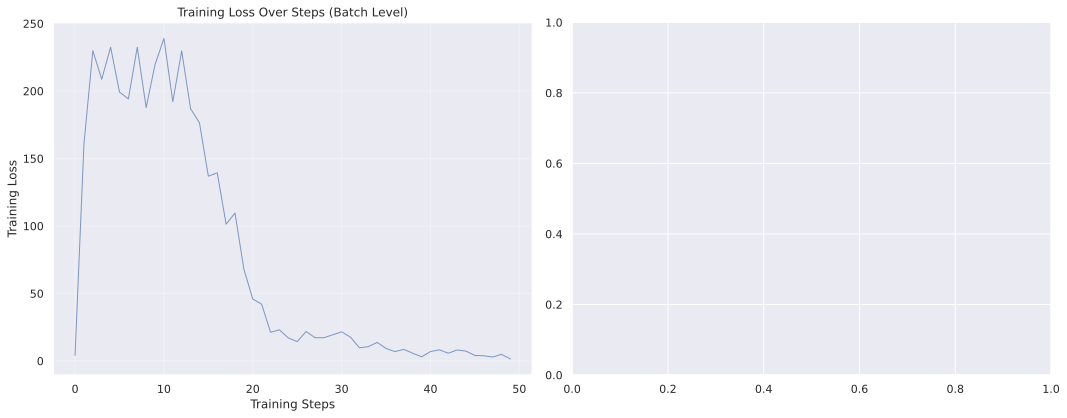

Final training loss: 1.4910


In [31]:
logreg.plot_losses()

Weighted F1: 0.942


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

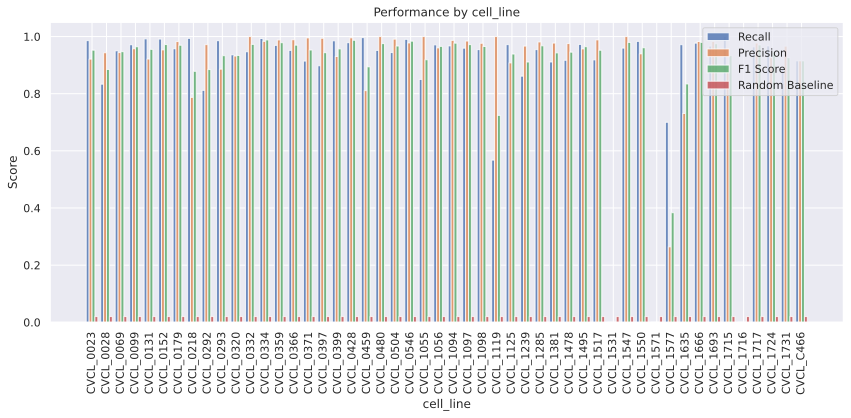

In [32]:
# eval subset
adata_eval = adata[:10000]
adata_eval = adata_eval.to_memory() if hasattr(adata_eval, "to_memory") else adata_eval

if hasattr(adata_eval.X, "compute"):
    adata_eval.X = adata_eval.X.compute()

logreg.plot_classification_report(adata_eval)

## Get features scores of different methods

In [33]:
df_modlyn_logreg = logreg.get_weights()
df_modlyn_logreg.head()

gene_name,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,TFPI,NDUFAF7,RBM5,MTMR7,SLC7A2,ARF5,SARM1,POLDIP2,PLXND1,AK2,CD38,FKBP4,KDM1A,RBM6,CAMKK1,RECQL,VPS50,HSPB6,ARHGAP33,NDUFAB1,PDK4,SLC22A16,ZMYND10,ABCB5,ARX,SLC25A13,ST7,CDC27,SLC4A1,CALCR,HCCS,DVL2,PRSS22,UPF1,SKAP2,SLC25A5,MCUB,HOXA11,POLR2J,DHX33,MEOX1,THSD7A,LIG3,RPAP3,ACSM3,REXO5,CIAPIN1,SPPL2B,ATOSB,COPZ2,PRKAR2B,MSL3,CREBBP,TSPOAP1,MPO,PON1,GCFC2,WDR54,CROT,ABCB4,...,DPY19L2P3-1,ENSG00000291214,ENSG00000291215,ENSG00000291216,LINC01347-1,ENSG00000291218,ENSG00000291219,ENSG00000291220,ENSG00000291221,ENSG00000291222,FAM86DP-1,ENSG00000291224,ENSG00000291225,ENSG00000291226,ENSG00000291227,ENSG00000291228,ENSG00000291229,ENSG00000291230,ENSG00000291231,ENSG00000291232,ENSG00000291233,ENSG00000291234,ENSG00000291235,ENSG00000291236,SOD2,ENSG00000291238,ENSG00000291239,ENSG00000291240,ENSG00000291241,ENSG00000291242,ENSG00000291243,ENSG00000291246,ENSG00000291247,ENSG00000291248,ENSG00000291249,ENSG00000291250,ENSG00000291251,ENSG00000291252,ENSG00000291253,ENSG00000291254,ENSG00000291255,ENSG00000291256,ENSG00000291257,ENSG00000291258,ENSG00000291259,ENSG00000291260,ENSG00000291261,ENSG00000291262,SMG1P7-1,ENSG00000291264,ENSG00000291265,SMG1P5-1,ENSG00000291267,ENSG00000291268,ENSG00000291269,ENSG00000291270,ENSG00000291271,ENSG00000291272,ENSG00000291273,ENSG00000291274,ENSG00000291275,ENSG00000291276,ENSG00000291277,ENSG00000291278,ENSG00000291279,ANKRD20A11P-1,COL6A4P1-1,ENSG00000291282,ENSG00000291283,ENSG00000291284,ENSG00000291285,ENSG00000291286,ENSG00000291287,ENSG00000291288,ENSG00000291289,ENSG00000291290,ENSG00000291291,ENSG00000291292,ENSG00000291293,ENSG00000291294,ENSG00000291295,ENSG00000291296,ENSG00000291297,ENSG00000291298,ENSG00000291299,PRSS30P-1,ENSG00000291301,ENSG00000291302,ENSG00000291303,ENSG00000291306,POLGARF,ENSG00000291308,LY6S,ENSG00000291310,ENSG00000291312,ENSG00000291313,ENSG00000291314,ENSG00000291315,ENSG00000291316,TMEM276
CVCL_0023,-0.072169,-0.001782,-0.253420,0.065178,-0.105779,-0.001987,-0.161486,0.064726,0.345648,-0.122356,0.030515,-0.382999,-0.409256,0.074057,-0.000260,0.047803,-0.146368,-0.086480,-0.231688,0.091047,0.004395,0.362339,0.167888,0.770146,0.014816,0.000374,-0.003875,-0.234518,-0.164976,0.402599,-0.046038,-0.005936,0.205344,-0.139414,-0.047620,0.072820,0.045614,0.181548,0.084620,0.267123,0.435146,0.025976,0.079984,0.013431,-0.361021,0.081737,0.164964,0.004023,-0.312792,-0.004473,0.470313,0.161411,-0.153540,0.475248,0.010871,-0.287485,0.324269,0.003048,-0.061986,0.197627,-0.197441,0.002182,0.052494,-0.002487,0.002376,0.027470,0.114913,0.560219,-0.003240,0.050618,-0.136922,0.110338,-0.001225,-0.360374,0.192702,0.432135,0.068588,0.059247,0.056717,-0.136761,-0.003831,0.029181,-0.098333,0.597748,0.056844,-0.035246,0.149224,-0.090831,-0.005264,-0.081047,-0.005119,0.051607,0.054285,-0.001686,0.002799,-0.065433,-0.046358,0.060087,0.143705,0.045878,...,-0.003750,0.656235,-0.001750,0.004126,0.053257,-0.001964,0.001087,0.003787,0.002000,0.003552,0.031506,0.099230,-0.035613,0.004144,0.004135,-0.038874,-0.003880,0.002657,0.003221,0.050653,-0.003933,0.071562,0.001616,-0.003059,0.761539,-0.004090,-0.002690,-0.003076,0.003457,0.002830,0.003522,0.002355,-0.002543,0.003614,-0.001696,0.125483,0.003966,-0.003363,0.004107,-0.001464,-0.001881,-0.003552,0.003171,-0.063697,-0.082815,-0.004063,0.001957,-0.003236,0.002036,0.003982,0.082803,0.004091,0.000484,-0.004083,0.002524,0.002997,-0.003088,0.050780,-0.003394,-0.004073,-0.003045,-0.060353,0.004143,-0.003000,0.003574,0.003350,-0.001505,0.002071,-0.043347,0.004141,0.001907,0.004628,-0.002736,-0.005997,-0.003575,-0.003747,0.003019,-0.003068,-0.002028,0.002594,-0.004082,-0.003968,0.002490,0.004005,-0.015930,-0.004040,0.005229,-0.002081,0.003468,0.004093,0.002205,0.003866,-0.004129,0.002984,0.004

In [ ]:
sc.tl.rank_genes_groups(adata, "cell_line", method="logreg", key_added="sc_logreg")
df_scanpy_logreg = sc.get.rank_genes_groups_df(
    adata, group=None, key="sc_logreg"
).pivot(index="group", columns="names", values="scores")
df_scanpy_logreg.attrs["method_name"] = "scanpy_logreg"
df_scanpy_logreg.head()

In [ ]:
sc.tl.rank_genes_groups(adata, "cell_line", method="wilcoxon", key_added="sc_wilcoxon")
df_scanpy_wilcoxon = sc.get.rank_genes_groups_df(
    adata, group=None, key="sc_wilcoxon"
).pivot(index="group", columns="names", values="scores")
df_scanpy_wilcoxon.attrs["method_name"] = "scanpy_wilcoxon"
df_scanpy_wilcoxon.head()

## Compare feature selection results

In [ ]:
compare = mn.eval.CompareScoresJaccard(
    [df_modlyn_logreg, df_scanpy_logreg, df_scanpy_wilcoxon], n_top_values=[5, 10, 25]
)

In [ ]:
compare.plot_heatmaps()

In [ ]:
compare.compute_jaccard_comparison()
compare.plot_jaccard_comparison()

In [ ]:
ln.finish()